## Imports
---
Before we begin, we import the top-level necessary packages. Moreover, we include the algorithm specific packages from the local directories.

In [1]:
# Get the system environment variables.
import sys

# General Imports:
import numpy as np
from time import time

# Variational:
from auxiliary import collect_obs
from auxiliary import initialize_Ab0
from core import smoothing

# Plotting:
from matplotlib.pyplot import figure, show, rcParams

%matplotlib inline

# Change the default figure size.
rcParams['figure.figsize'] = (14.0, 7.0)

## Simulation for Lorenz 63

 >> Python version is: 3.6.1 |Anaconda custom (x86_64)| (default, Mar 22 2017, 19:25:17) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]

System tested: Lorenz 63, T=[0,20]

 Lorenz'63 - trajectory



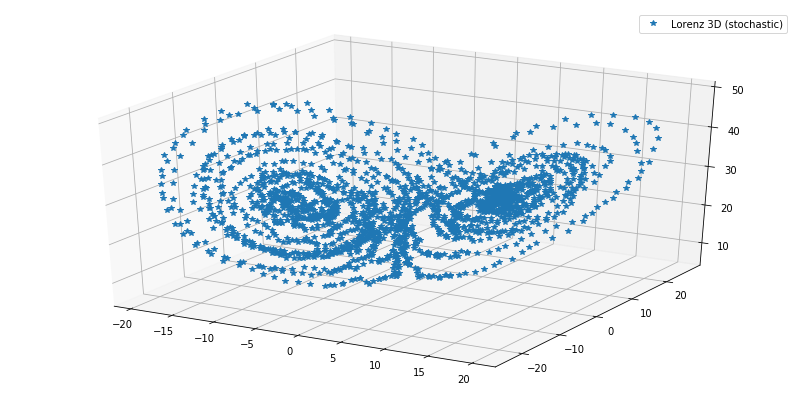

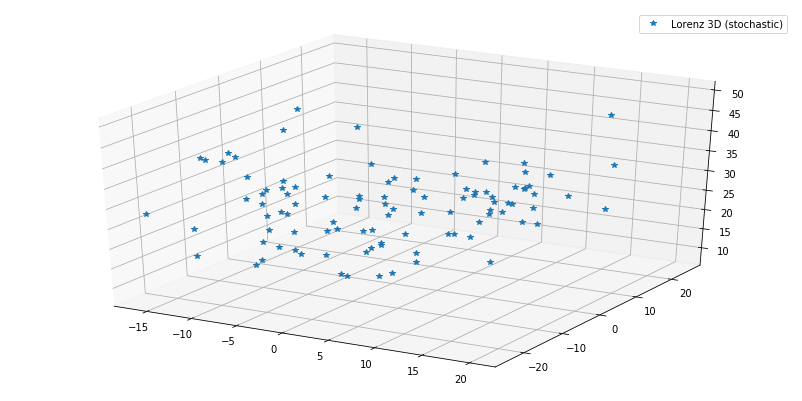

 [VGPA] (Smoothing) Experiment in progress. Please wait ...
 >> SCG optimization
 0:	fx=5484.588	sum(gx)=18244.155
 1:	fx=4974.517	sum(gx)=15424.132
 2:	fx=4886.753	sum(gx)=13760.538
 3:	fx=4867.344	sum(gx)=13400.889
 4:	fx=4862.641	sum(gx)=13314.065
 5:	fx=4861.475	sum(gx)=13292.467
 6:	fx=4861.184	sum(gx)=13287.075
 7:	fx=4861.111	sum(gx)=13285.727
 8:	fx=4861.093	sum(gx)=13285.390
 9:	fx=4861.088	sum(gx)=13285.306
 10:	fx=4861.087	sum(gx)=13285.285
 11:	fx=4861.087	sum(gx)=13285.279
 12:	fx=4861.087	sum(gx)=13285.278
 13:	fx=4861.087	sum(gx)=13285.278
 14:	fx=4861.087	sum(gx)=13285.278
 15:	fx=4861.087	sum(gx)=13285.278
 16:	fx=4861.087	sum(gx)=13285.278
 17:	fx=4861.087	sum(gx)=13285.278
 18:	fx=4861.087	sum(gx)=13285.278
 19:	fx=4861.087	sum(gx)=13285.278
 [VGPA] (Smoothing) Experiment ended in 116.23 seconds.
 Minimum var. free energy is 4861.09.



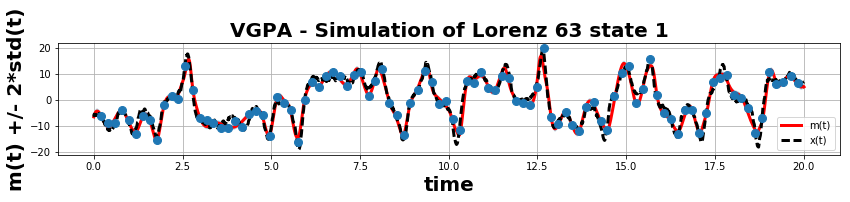

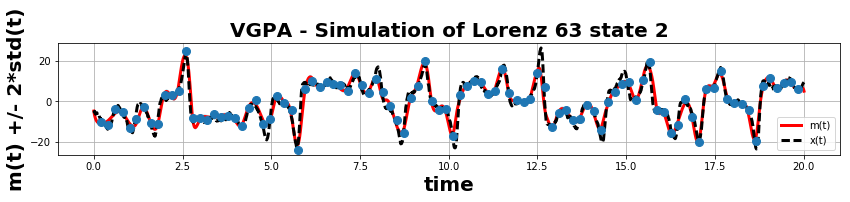

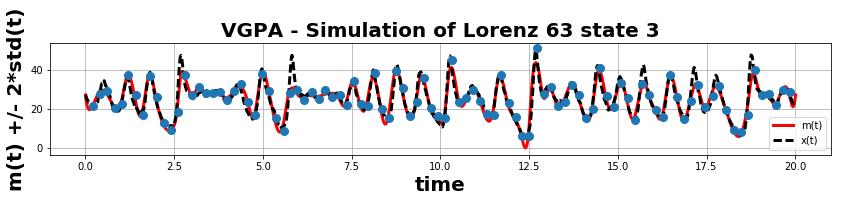

In [2]:
from dynamics import sys_lorenz_63_ut as dynamics

# Show current python version.
print(" >> Python version is: {0}\n".format(sys.version))

'''
TIME-WINDOW PARAMETERS:
'''

# Initial, final and time step.
t0 = 0; 
tf = 20; 
dt = 0.01

# Define the time-window of inference.
Tw = np.arange(t0, tf + dt, dt)

# Number of discretized points.
N = Tw.shape[0]

'''
SYSTEM SPECIFIC PARAMETERS:
'''

# Dimensionality of the system.
D = 3

# Stochastic Noise (variance).
sigma_Noise = 10 * np.eye(D)

# Drift parameters (sigma, rho, beta).
theta_Drift = np.array([10, 28, 8. / 3])

# Observation Noise (variance).
obs_Noise = 2 * np.eye(D)

# Print a message.
print("System tested: {0}, T=[{1},{2}]\n".format('Lorenz 63',t0,tf))

'''
OBSERVATIONS SECTION:
'''

# Create the (artificial) true trajectory.
xt_true = dynamics.system_path(Tw, sigma_Noise, theta_Drift)

# Define the observation density (# of observations per time unit).
n_Obs = 5

# We need at least one observation (per time unit)
n_Obs = np.max([n_Obs, 1])

# Sample the noisy observations from the true path.
obsX, obsY = collect_obs.collect_obs(xt_true, Tw, n_Obs, obs_Noise)

dynamics.plot_sample_path(xt_true)

dynamics.plot_sample_path(obsY)

# Observation operator: np.eye(D)
H = np.eye(D)

'''
PRIOR MOMEMTS:
'''

# Prior moment of initial condition noise variance.
# p(x0) ~ N(mu, tau0)
tau0 = 0.5 * np.eye(D)

# Get the true sample value at time t=0
prior_x0 = {'mu0': xt_true[0], 'tau0': tau0}

# Initial mean m(t=0)
m0 = xt_true[0] + 0.1 * np.random.randn(1)

# Initial covariance matrix S(t=0): K*np.eye(D)
S0 = 0.25 * np.eye(D)


'''
PACKING PARAMETERS:
'''

# ODE solver: {'Euler', 'Heun', 'RK2', 'RK4'}
ode_method = 'Euler'

# Create a dictionary to hold all the model parameters.
sde_struct = {
    'Sig': sigma_Noise, 
    'theta': theta_Drift, 
    'Rig': obs_Noise,
    'D': D, 
    'H': H, 
    'obsX': obsX,
    'obsY': obsY,
    'px0': prior_x0,
    'Tw': Tw, 
    'dt': dt, 
    'N': N, 
    'ode_method': ode_method,
    'checkGradf': False
}

'''
INITIALIZATION:
'''

# Maximum number of iterations.
nit = 500

# Generate initial variational parameters (initial search point).
Ab0 = initialize_Ab0.initialize_Ab0(S0, sde_struct)

# Main Operation.
print(' [VGPA] (Smoothing) Experiment in progress. Please wait ...')

# Start the timer.
tic = time()

# Full Variational approximation.
Fmin, mParam = smoothing.smoothing(dynamics.energy_mode, Ab0, m0, S0, sde_struct, nit)

# Stop the timer.
ttime = time() - tic

# Display termination message.
print(' [VGPA] (Smoothing) Experiment ended in {0:.2f} seconds.'.format(ttime))

# Display the minimum free energy.
print(' Minimum var. free energy is {0:.2f}.\n'.format(Fmin))

'''
PLOTTING SECTION:
'''

for i in range(3):
    # Extract here the quantities for ploting.
    mt = mParam['mt'][:, i] # marginal   mean   values.
    St = [mParam['St'][j, :, :][i, i] for j in range(N)] # marginal variance values.

    # Create a new figure.
    ax = figure().add_subplot(3, 1, i + 1)

    # Prepare the error-bars.
    upper_line = mt + 2 * np.sqrt(St)
    lower_line = mt - 2 * np.sqrt(St)
    ax.fill_between(Tw, upper_line.flatten(), lower_line.flatten(), facecolor='lightblue')

    # Add the mean path: m(t) and the true sample path: x(t).
    ax.plot(Tw, mt, 'r-', linewidth=3, label='m(t)')
    ax.plot(Tw, xt_true[:, i], 'k--', linewidth=3, label='x(t)')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Add the (noisy) observations.
    obsX = (np.array(obsX) + 1).tolist()
    ax.plot(Tw[obsX], obsY[:, i], 'o', markersize=8)

    # Setup the labels.
    ax.set_ylabel('m(t) +/- 2*std(t)', fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.set_xlabel('time', fontdict={'fontsize': 20, 'fontweight': 'bold'})
    ax.set_title('VGPA - Simulation of Lorenz 63 state {}'.format(i + 1), fontdict={'fontsize': 20, 'fontweight': 'bold'})

    # Show-time.
    show()

    # End-Of-File